# Indiana Pines

1. Import dependencies

In [1]:
import random
import torch
import multiprocessing
import numpy as np

import torch.utils.data as data

from lightning import Trainer

from sklearn.model_selection import train_test_split
from src.data.indian_pines import load_indian_pines
from src.util.torch import resolve_torch_device
from src.model.hsic import HyperSpectralImageClassifier
from src.visualization.plot import plot_segmentation_comparison
from src.data.dataset_decorator import UnlabeledDatasetDecorator
from src.model.spectral_former import SpectralFormer
from src.visualization.plot import plot_numbers_distribution
from src.util.hsi import (
    extract_patches,
    reduce_hsi_dim,
    train_test_band_patch_split,
    preprocess_hsi,
    extract_band_patches,
    PreProcessType,
    DimReductionType,
)
from src.util.reporting import create_model_name, report_run, read_report_to_show, lightning_metrics
from src.util.list_ext import smooth_moving_average
from src.visualization.plot import plot_epoch_generic, plot_epoch_generic_comparison

2. Prepare env

In [2]:
dim = 64
depth = 5
heads = 4
mlp_dim = 8
dropout = 0.3
emb_dropout = 0.1
learning_rate = 5e-4
weight_decay = 5e-3
num_epochs = 300
scheduler_step_size = num_epochs // 10
scheduler_gamma = 0.9

In [3]:
batch_size = 64
patch_size = 7
band_patch = 3

target_dim = 75

pre_process_type = PreProcessType.STANDARTIZATION
dim_reduction_type = DimReductionType.PCA

In [4]:
torch.cuda.empty_cache()

In [5]:
torch.set_float32_matmul_precision("medium")

In [6]:
random_seed = 42

random.seed(random_seed)
torch.manual_seed(random_seed)
np.random.seed(random_seed)


device = resolve_torch_device()

In [7]:
f"Device is {device}"

'Device is cuda'

In [8]:
cpu_count = multiprocessing.cpu_count()

f"Setting num_workers to {cpu_count}"

'Setting num_workers to 24'

3. Load dataset

In [9]:
image, labels = load_indian_pines()

image_h, image_w, image_c = image.shape

In [10]:
num_classes = len(np.unique(labels))

f"Number of classes {num_classes}"

'Number of classes 17'

In [11]:
examples_per_class = [20] * num_classes

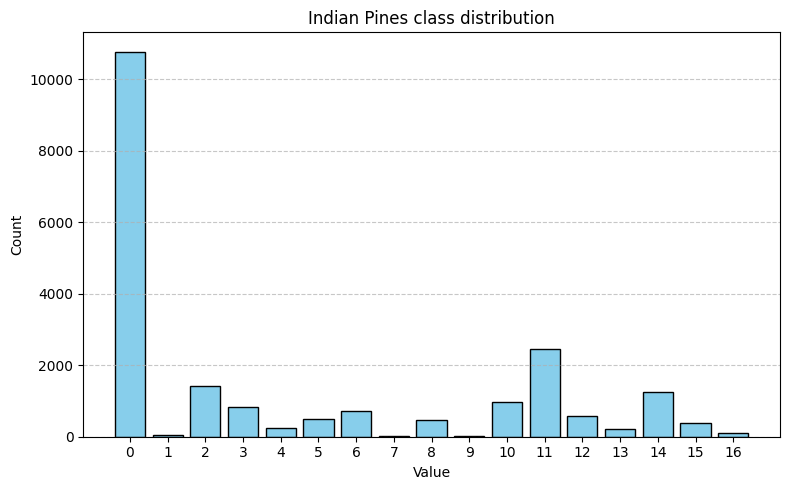

In [12]:
plot_numbers_distribution(labels.ravel(), desc="Indian Pines class distribution")

In [13]:
_, image = preprocess_hsi(image, pre_process_type)

In [14]:
_, target_dim, image = reduce_hsi_dim(
    image, target_dim, dim_reduction_type, device, random_seed
)

In [15]:
print(f"Image shape: {image.shape}")

x, y = extract_patches(image, labels, patch_size)

print(f"Patched image shape: {x.shape}")
print(f"Patched labels shape: {y.shape}")

x = extract_band_patches(x, band_patch)

print(f"Bandwise patched image shape: {x.shape}")

Image shape: (145, 145, 75)
Patched image shape: (21025, 7, 7, 75)
Patched labels shape: (21025,)
Bandwise patched image shape: (21025, 147, 75)


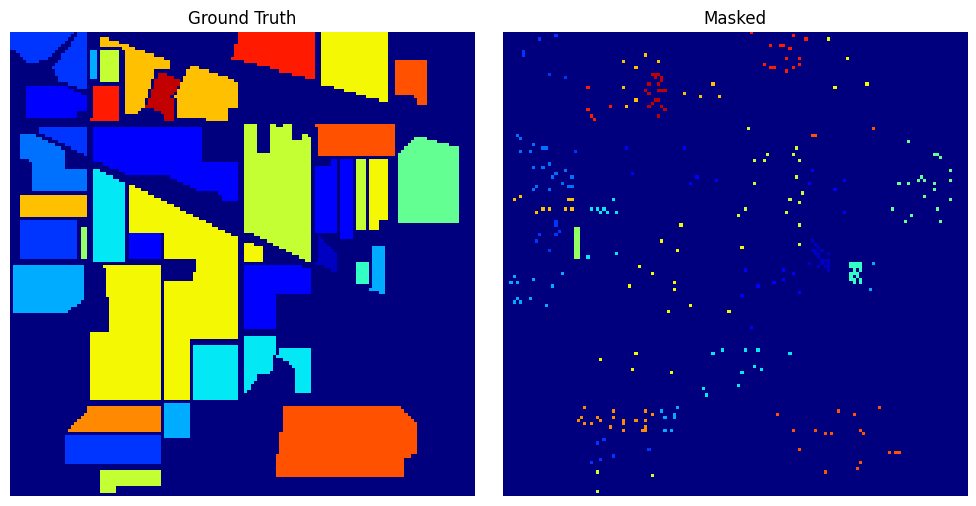

In [16]:
if examples_per_class:
    x_train, y_train, x_test, y_test, y_masked = train_test_band_patch_split(
        x, y, examples_per_class, "indian_pines"
    )

    plot_segmentation_comparison(
        y.reshape(image_h, image_w), y_masked.reshape(image_h, image_w), title2="Masked"
    )
else:
    x_train, x_test, y_train, y_test = train_test_split(
        x, y, test_size=0.2, random_state=random_seed, stratify=y
    )

# plot_numbers_distribution(y_train, desc="Train class distribution")

In [17]:
x_all = torch.tensor(x, dtype=torch.float32, device=device).permute(0, 2, 1)
y_all = torch.tensor(y, dtype=torch.long, device=device)
x_train = torch.tensor(x_train, dtype=torch.float32, device=device).permute(0, 2, 1)
y_train = torch.tensor(y_train, dtype=torch.long, device=device)
x_test = torch.tensor(x_test, dtype=torch.float32, device=device).permute(0, 2, 1)
y_test = torch.tensor(y_test, dtype=torch.long, device=device)

In [18]:
train_dataset = data.TensorDataset(x_train, y_train)
test_dataset = data.TensorDataset(x_test, y_test)
full_dataset = data.TensorDataset(x_all, y_all)

train_loader = data.DataLoader(
    dataset=train_dataset,
    batch_size=batch_size,
    shuffle=True,
    # num_workers=cpu_count,
    # persistent_workers=True,
)
test_loader = data.DataLoader(
    dataset=test_dataset,
    batch_size=batch_size,
    shuffle=False,
    # num_workers=cpu_count,
    # persistent_workers=True,
)
full_loader = data.DataLoader(
    dataset=full_dataset,
    batch_size=batch_size,
    shuffle=False,
    # num_workers=cpu_count,
    # persistent_workers=True,
)
predict_loader = data.DataLoader(
    dataset=UnlabeledDatasetDecorator(full_dataset),
    batch_size=batch_size,
    shuffle=False,
    # num_workers=cpu_count,
    # persistent_workers=True,
)

In [19]:
f"Training samples: {len(train_dataset)}, Testing samples: {len(test_dataset)}"

'Training samples: 340, Testing samples: 20685'

4. Train model

In [20]:
model = HyperSpectralImageClassifier(
    SpectralFormer(
        image_size=patch_size,
        near_band=band_patch,
        num_patches=target_dim,
        num_classes=num_classes,
        dim=dim,
        depth=depth,
        heads=heads,
        mlp_dim=mlp_dim,
        dropout=dropout,
        emb_dropout=emb_dropout,
    ),
    num_classes,
    lr=learning_rate,
    weight_decay=weight_decay,
    scheduler_step_size=scheduler_step_size,
    scheduler_gamma=scheduler_gamma,
)

trainer = Trainer(accelerator="auto", max_epochs=num_epochs)

You are using the plain ModelCheckpoint callback. Consider using LitModelCheckpoint which with seamless uploading to Model registry.
GPU available: True (cuda), used: True
TPU available: False, using: 0 TPU cores
HPU available: False, using: 0 HPUs
/home/melal/Workspace/spatial-regulated-self-training/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/logger_connector/logger_connector.py:76: Starting from v1.9.0, `tensorboardX` has been removed as a dependency of the `lightning.pytorch` package, due to potential conflicts with other packages in the ML ecosystem. For this reason, `logger=True` will use `CSVLogger` as the default logger, unless the `tensorboard` or `tensorboardX` packages are found. Please `pip install lightning[extra]` or one of them to enable TensorBoard support by default


In [21]:
trainer.fit(model, train_loader, test_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]

  | Name             | Type                 | Params | Mode 
------------------------------------------------------------------
0 | net              | SpectralFormer       | 139 K  | train
1 | f1               | MulticlassF1Score    | 0      | train
2 | overall_accuracy | MulticlassAccuracy   | 0      | train
3 | average_accuracy | MulticlassAccuracy   | 0      | train
4 | kappa            | MulticlassCohenKappa | 0      | train
------------------------------------------------------------------
139 K     Trainable params
0         Non-trainable params
139 K     Total params
0.558     Total estimated model params size (MB)
112       Modules in train mode
0         Modules in eval mode


Sanity Checking: |          | 0/? [00:00<?, ?it/s]

/home/melal/Workspace/spatial-regulated-self-training/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'val_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.
/home/melal/Workspace/spatial-regulated-self-training/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'train_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.
/home/melal/Workspace/spatial-regulated-self-training/.venv/lib/python3.12/site-packages/lightning/pytorch/loops/fit_loop.py:310: The number of training batches (6) is smaller than the logging interval Trainer(log_every_n_steps=50). Set a lower value for log_every_n_steps if you want to see logs for

Training: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

Validation: |          | 0/? [00:00<?, ?it/s]

`Trainer.fit` stopped: `max_epochs=300` reached.


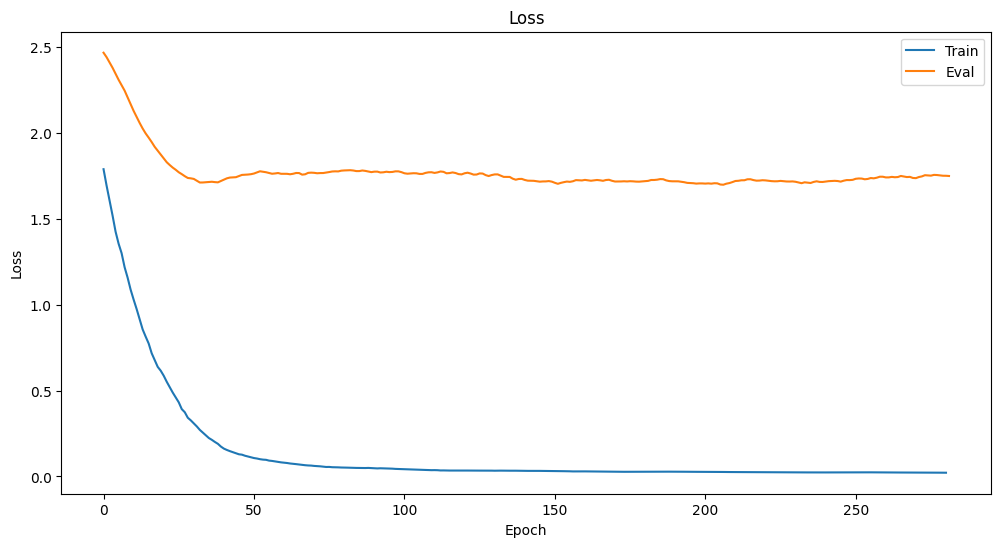

In [22]:
smothed_train = smooth_moving_average([it.loss.cpu() for it in model.train_metrics], 20)
smothed_eval = smooth_moving_average([it.loss.cpu() for it in model.val_metrics], 20)

plot_epoch_generic_comparison(smothed_train, smothed_eval)

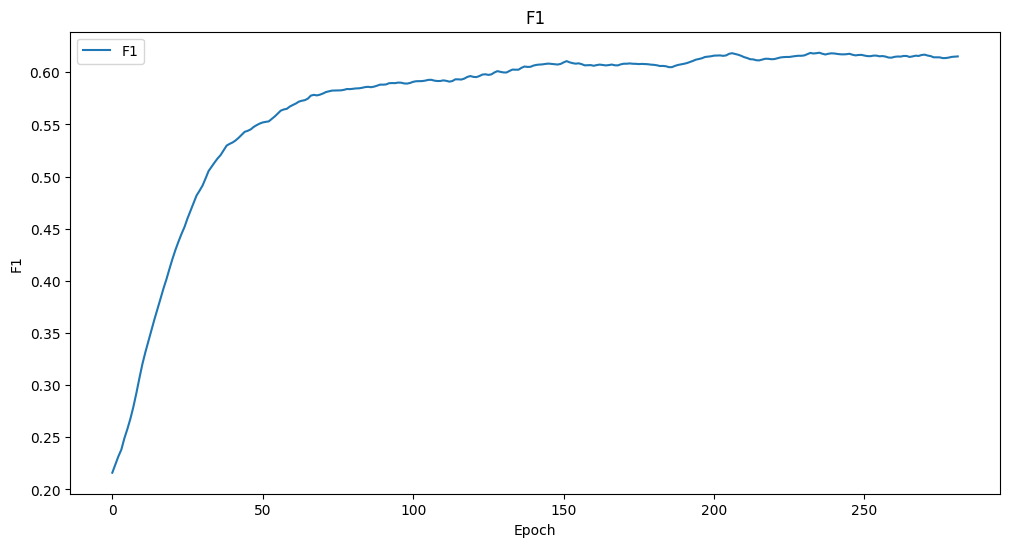

In [23]:
smooth_f1 = smooth_moving_average([it.f1.cpu() for it in model.val_metrics], 20)

plot_epoch_generic(smooth_f1, desc="F1")

In [24]:
validation_result = trainer.validate(model, full_loader)

validation_result

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]


Validation: |          | 0/? [00:00<?, ?it/s]

────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
     Validate metric           DataLoader 0
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────
  val_average_accuracy      0.5920094847679138
         val_f1             0.6299334168434143
        val_kappa           0.42821329832077026
        val_loss             1.709462285041809
  val_overall_accuracy      0.32859405875205994
────────────────────────────────────────────────────────────────────────────────────────────────────────────────────────


[{'val_loss': 1.709462285041809,
  'val_f1': 0.6299334168434143,
  'val_overall_accuracy': 0.32859405875205994,
  'val_average_accuracy': 0.5920094847679138,
  'val_kappa': 0.42821329832077026}]

5. Display prediction

In [25]:
y_pred = trainer.predict(model, predict_loader)

LOCAL_RANK: 0 - CUDA_VISIBLE_DEVICES: [0]
/home/melal/Workspace/spatial-regulated-self-training/.venv/lib/python3.12/site-packages/lightning/pytorch/trainer/connectors/data_connector.py:425: The 'predict_dataloader' does not have many workers which may be a bottleneck. Consider increasing the value of the `num_workers` argument` to `num_workers=23` in the `DataLoader` to improve performance.


Predicting: |          | 0/? [00:00<?, ?it/s]

In [26]:
y_pred = torch.cat(y_pred, dim=0)
y_pred = torch.argmax(y_pred, dim=1)
y_pred = y_pred.reshape(image_h, image_w)

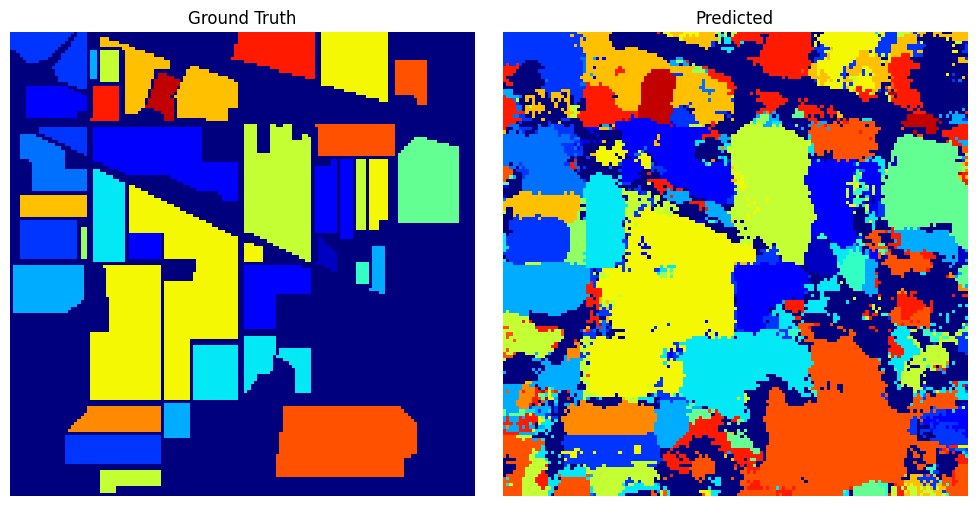

In [27]:
plot_segmentation_comparison(y.reshape(image_h, image_w), y_pred.numpy())

6. Write report

In [ ]:
model_name = create_model_name("indian_pines_", examples_per_class)
model_category = "specteal_former"

run_params = {
    "num_epochs": num_epochs,
    "batch_size": batch_size,
    "patch_size": patch_size,
    "target_dim": target_dim,
    "pre_process_type": str(pre_process_type),
    "dim_reduction_type": str(dim_reduction_type),
}

report_run(
    model_name=model_name,
    model_category=model_category,
    run_desc="With scheduling, incresed dropout and weight decay",
    run_params=run_params | model.get_params(),
    run_metrics=lightning_metrics(validation_result),
)

PosixPath('/home/melal/Workspace/spatial-regulated-self-training/reports/runs/indian_pines__2020202020202020202020202020202020.csv')

In [29]:
read_report_to_show(model_name, sort_by_metric="f1")

,timestamp,model_category,run_desc,params,loss,f1,OA,AA,kappa
21,2025-05-25T13:49:18.465537+00:00,specteal_former,"With scheduling, incresed dropout and weight d...","{""hidden_dim"": 64, ""num_layers"": 5, ""num_heads...",1.709462,0.629933,3.285941e-01,0.592009,0.428213
19,2025-05-25T13:11:09.295934+00:00,specteal_former,"With scheduling, incresed dropout","{""hidden_dim"": 64, ""num_layers"": 5, ""num_heads...",1.884388,0.610363,3.212764e-01,0.573888,0.418024
17,2025-05-25T12:28:13.957191+00:00,specteal_former,With scheduling,"{""hidden_dim"": 64, ""num_layers"": 5, ""num_heads...",2.039043,0.588829,3.162847e-01,0.557241,0.407733
18,2025-05-25T12:48:49.301608+00:00,specteal_former,"With scheduling, incresed dropout","{""hidden_dim"": 64, ""num_layers"": 5, ""num_heads...",2.218621,0.575685,3.045633e-01,0.548062,0.399809
16,2025-05-25T11:54:50.924387+00:00,specteal_former,Default run,"{""hidden_dim"": 64, ""num_layers"": 5, ""num_heads...",2.187469,0.560617,2.933610e-01,0.531653,0.385957
20,2025-05-25T13:31:55.937456+00:00,specteal_former,"With scheduling, incresed dropout and weight d...","{""hidden_dim"": 64, ""num_layers"": 5, ""num_heads...",1.904269,0.550501,2.584340e-01,0.511486,0.363580
8,2025-05-25T00:13:59.916485+00:00,lenet,"A lot more epochs, PCA and scheduler","{""learning_rate"": 0.001, ""num_epochs"": 1000, ""...",2.457449,0.489860,2.897493e-01,0.478478,NaN
1,2025-05-24T19:21:48.509234+00:00,lenet,Default run (more epochs),"{""learning_rate"": 0.001, ""num_epochs"": 100, ""b...",2.559524,0.489064,2.364114e-01,0.443092,NaN
15,2025-05-25T11:31:53.271370+00:00,lenet,"More epochs, PCA, norm, and scheduler","{""learning_rate"": 0.001, ""num_epochs"": 1000, ""...",2.469688,0.473372,2.799799e-01,0.462592,NaN
7,2025-05-25T00:11:16.070258+00:00,lenet,"More epochs, PCA and scheduler","{""learning_rate"": 0.001, ""num_epochs"": 300, ""b...",2.513368,0.472783,2.816274e-01,0.463876,NaN


In [30]:
read_report_to_show(model_name, sort_by_metric="f1", model_category=model_category)

,timestamp,run_desc,params,loss,f1,OA,AA,kappa
21,2025-05-25T13:49:18.465537+00:00,"With scheduling, incresed dropout and weight d...","{""hidden_dim"": 64, ""num_layers"": 5, ""num_heads...",1.709462,0.629933,0.328594,0.592009,0.428213
19,2025-05-25T13:11:09.295934+00:00,"With scheduling, incresed dropout","{""hidden_dim"": 64, ""num_layers"": 5, ""num_heads...",1.884388,0.610363,0.321276,0.573888,0.418024
17,2025-05-25T12:28:13.957191+00:00,With scheduling,"{""hidden_dim"": 64, ""num_layers"": 5, ""num_heads...",2.039043,0.588829,0.316285,0.557241,0.407733
18,2025-05-25T12:48:49.301608+00:00,"With scheduling, incresed dropout","{""hidden_dim"": 64, ""num_layers"": 5, ""num_heads...",2.218621,0.575685,0.304563,0.548062,0.399809
16,2025-05-25T11:54:50.924387+00:00,Default run,"{""hidden_dim"": 64, ""num_layers"": 5, ""num_heads...",2.187469,0.560617,0.293361,0.531653,0.385957
20,2025-05-25T13:31:55.937456+00:00,"With scheduling, incresed dropout and weight d...","{""hidden_dim"": 64, ""num_layers"": 5, ""num_heads...",1.904269,0.550501,0.258434,0.511486,0.363580
